In [ ]:
# plt 한글 깨짐을 해결하기 위해 이 코드를 실행 후 런타임 재시작

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
# 런타임 다시시작 후 실행

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from random import randint
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [5]:
train=pd.read_csv('/content/drive/MyDrive/easy_train.csv',encoding='utf-8')
submit=pd.read_csv('/content/drive/MyDrive/esay_test.csv',encoding='utf-8')
sample_submission=pd.read_csv('/content/drive/MyDrive/easy_sample_submission_7.csv',encoding='utf-8')      ### ai허브에 제출하기 위한 csv

In [6]:
train.shape, submit.shape

((2420565, 27), (313267, 24))

In [7]:
train.head()

,index,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압,label_역률평균,label_전류고조파평균,label_전압고조파평균
0,0,2248930.5,28963.0,20237.0,59.854076,45.197918,259.916656,449.916656,47.500,8663.0,...,260.75,452.75,10417.0,7304.0,48.71875,260.75,448.75,정상,경고,주의
1,1,0.0,0.0,0.0,0.000000,101.312500,0.000000,0.000000,24.375,0.0,...,0.00,0.00,0.0,0.0,100.68750,0.00,0.00,경고,정상,정상
2,2,5375707.0,35244.0,19826.0,59.975650,107.385414,125.416664,216.750000,18.750,11988.0,...,125.25,216.25,12236.0,6170.0,109.56250,125.00,216.25,정상,정상,주의
3,3,17781200.0,77056.0,39520.0,59.863000,244.854000,118.083000,205.333000,23.125,25796.0,...,118.75,118.75,24992.0,13704.0,242.18800,118.00,118.00,정상,정상,경고
4,4,10143988.0,0.0,0.0,59.798140,0.000000,133.750000,231.500000,26.875,0.0,...,134.50,231.50,0.0,0.0,0.00000,133.00,230.25,경고,정상,정상


In [8]:
train.dtypes

index              int64
누적전력량            float64
유효전력평균           float64
무효전력평균           float64
주파수              float64
전류평균             float64
상전압평균            float64
선간전압평균           float64
온도               float64
R상유효전력           float64
R상무효전력           float64
R상전류             float64
R상전압             float64
R상선간전압           float64
S상유효전력           float64
S상무효전력           float64
S상전류             float64
S상전압             float64
S상선간전압           float64
T상유효전력           float64
T상무효전력           float64
T상전류             float64
T상전압             float64
T상선간전압           float64
label_역률평균        object
label_전류고조파평균     object
label_전압고조파평균     object
dtype: object

In [9]:
train.columns

Index(['index', '누적전력량', '유효전력평균', '무효전력평균', '주파수', '전류평균', '상전압평균', '선간전압평균',
       '온도', 'R상유효전력', 'R상무효전력', 'R상전류', 'R상전압', 'R상선간전압', 'S상유효전력', 'S상무효전력',
       'S상전류', 'S상전압', 'S상선간전압', 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압',
       'label_역률평균', 'label_전류고조파평균', 'label_전압고조파평균'],
      dtype='object')

In [10]:
ifydf = train.dropna()              ##### 전선이 전부 Y결선인지 확인하기 위한 데이터프레임 생성 #####

In [11]:
ifydf['Y결선선간전압'] = ifydf['상전압평균']*(3**(1/2))
ifydf[(ifydf['Y결선선간전압']*0.95 <= ifydf['선간전압평균']) & (ifydf['Y결선선간전압']*1.05 >= ifydf['선간전압평균'])]
##### 선간전압이 상전압의 루트3 배이면 Y결선 ####
##### drop된 결측치들을 제외하면 row 수가 거의 동일하기에 Y결선임을 알 수 있다. #####

,index,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압,label_역률평균,label_전류고조파평균,label_전압고조파평균,Y결선선간전압
0,0,2248930.50,28963.0,20237.0,59.854076,45.197918,259.916656,449.916656,47.5000,8663.00,...,452.750,10417.00,7304.00,48.71875,260.750,448.750,정상,경고,주의,450.188854
1,1,0.00,0.0,0.0,0.000000,101.312500,0.000000,0.000000,24.3750,0.00,...,0.000,0.00,0.00,100.68750,0.000,0.000,경고,정상,정상,0.000000
2,2,5375707.00,35244.0,19826.0,59.975650,107.385414,125.416664,216.750000,18.7500,11988.00,...,216.250,12236.00,6170.00,109.56250,125.000,216.250,정상,정상,주의,217.228034
3,3,17781200.00,77056.0,39520.0,59.863000,244.854000,118.083000,205.333000,23.1250,25796.00,...,118.750,24992.00,13704.00,242.18800,118.000,118.000,정상,정상,경고,204.525756
4,4,10143988.00,0.0,0.0,59.798140,0.000000,133.750000,231.500000,26.8750,0.00,...,231.500,0.00,0.00,0.00000,133.000,230.250,경고,정상,정상,231.661796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420560,2420561,6229905.00,25925.5,22606.0,57.945000,52.833000,215.327000,372.958000,19.0630,8631.50,...,216.628,7818.50,7867.00,51.12500,215.128,215.128,주의,정상,경고,372.957304
2420561,2420562,6057307.50,91244.0,47068.0,59.928820,152.156250,224.416672,388.583344,33.7500,30128.00,...,386.250,29052.00,14496.00,145.18750,223.250,388.750,정상,정상,주의,388.701078
2420562,2420563,7966820.00,16822.0,11924.8,59.914000,31.363100,219.233000,379.862000,17.3214,5157.84,...,219.276,5954.98,4172.97,32.79530,219.560,219.560,정상,경고,경고,379.722695
2420563,2420564,0.00,0.0,0.0,0.000000,44.572918,0.000000,0.000000,34.3750,0.00,...,0.000,0.00,0.00,41.96875,0.000,0.000,경고,경고,정상,0.000000


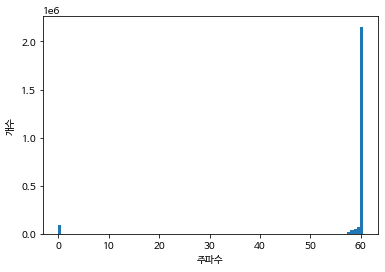

In [13]:
### 보통 정격주파수는 60Hz ###

bins = 100

plt.hist(ifydf['주파수'], bins)
plt.xlabel('주파수')
plt.ylabel('개수')

plt.show()

In [14]:
ifydf[ifydf['주파수']==0].loc[:,['유효전력평균','무효전력평균']].value_counts()                 #### 주파수가 0이면 측정한 부하설비가 멈춘 상태 임을 알 수 있습니다. ####

유효전력평균  무효전력평균
0.0     0.0       88161
dtype: int64

In [15]:
submit

,ID,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상유효전력,S상무효전력,S상전류,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압
0,0,5.471566e+06,92992.0,58520.00,59.826096,284.125000,129.416672,224.000000,26.875,30856.0,...,31472.0,19440.0,286.7500,129.500,224.000,30664.0,19048.0,280.3125,129.250,223.750
1,1,1.814760e-01,0.0,0.00,59.816770,0.000000,229.333328,396.916656,23.125,0.0,...,0.0,0.0,0.0000,229.500,395.000,0.0,0.0,0.0000,228.000,396.500
2,2,1.882077e+07,41165.0,11259.00,59.929000,62.302000,228.333000,395.000000,15.000,13584.0,...,14114.0,3904.0,63.9690,228.750,228.750,13467.0,3557.0,61.2810,227.500,227.500
3,3,1.425333e+07,72496.0,46050.00,59.826096,131.833328,216.250000,374.166656,28.125,25164.0,...,24656.0,16654.0,136.1875,217.250,374.500,22676.0,15068.0,125.8750,215.500,372.500
4,4,3.713425e+06,13205.5,21464.75,58.975000,39.125000,215.995000,374.113000,10.000,4327.5,...,5432.5,7740.5,43.5000,217.289,217.289,3445.5,7653.0,39.1250,216.078,216.078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313262,313263,2.969156e+06,0.0,0.00,59.854070,0.000000,264.083344,457.250000,29.375,0.0,...,0.0,0.0,0.0000,265.250,458.250,0.0,0.0,0.0000,263.500,455.250
313263,313264,8.162921e+05,0.0,0.00,59.854103,0.000000,226.083328,391.166656,28.125,0.0,...,0.0,0.0,0.0000,226.250,392.250,0.0,0.0,0.0000,226.500,390.750
313264,313265,9.445837e+06,0.0,0.00,59.863403,0.000000,130.500000,225.916672,26.875,0.0,...,0.0,0.0,0.0000,131.250,225.750,0.0,0.0,0.0000,129.500,224.500
313265,313266,1.803930e+07,0.0,0.00,59.948000,0.000000,265.667000,460.000000,29.375,0.0,...,0.0,0.0,0.0000,267.000,267.000,0.0,0.0,0.0000,264.500,264.500


In [16]:
sample_submission

,ID,label_역률평균,label_전류고조파평균,label_전압고조파평균
0,0,정상,정상,정상
1,1,정상,정상,정상
2,2,정상,정상,정상
3,3,정상,정상,정상
4,4,정상,정상,정상
...,...,...,...,...
313262,313263,정상,정상,정상
313263,313264,정상,정상,정상
313264,313265,정상,정상,정상
313265,313266,정상,정상,정상


# train의 NaN값
### case1
'누적전력량', '유효전력평균', '무효전력평균', '주파수', '전류평균', '상전압평균', '선간전압평균', '온도'
</br>
</br>
### case2
'R상유효전력', 'R상무효전력', 'R상전류', 'R상전압', 'R상선간전압', 'S상유효전력', 'S상무효전력', 'S상전류', 'S상전압', 'S상선간전압', 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압'
</br>
</br>
### case3
'S상유효전력', 'S상무효전력', 'S상전류', 'S상전압', 'S상선간전압', 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압'
</br>
</br>
### case4
'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압'
</br>
</br>
### case5
ALL NaN

In [17]:
train.isnull().sum()

index               0
누적전력량              17
유효전력평균             17
무효전력평균             17
주파수                17
전류평균               17
상전압평균              17
선간전압평균             17
온도                 17
R상유효전력             18
R상무효전력             18
R상전류               18
R상전압               18
R상선간전압             18
S상유효전력           1380
S상무효전력           1380
S상전류             1380
S상전압             1380
S상선간전압           1380
T상유효전력           2898
T상무효전력           2898
T상전류             2898
T상전압             2898
T상선간전압           2898
label_역률평균          0
label_전류고조파평균       0
label_전압고조파평균       0
dtype: int64

In [18]:
train[train['누적전력량'].isnull()]              ### '누적전력량', '유효전력평균', '무효전력평균', '주파수', '전류평균', '상전압평균', '선간전압평균', '온도' ###

,index,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압,label_역률평균,label_전류고조파평균,label_전압고조파평균
58148,58148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,128.625,222.125,0.0,0.0,0.00000,128.500,222.250,경고,정상,주의
84362,84362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25752.0,...,123.250,213.750,25568.0,14432.0,238.37500,122.750,213.750,정상,정상,경고
112756,112756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25304.0,...,117.750,203.750,24952.0,13256.0,242.43750,117.000,204.000,정상,정상,경고
134213,134213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37696.0,...,228.000,391.750,34266.0,14348.0,165.03125,226.125,393.375,정상,주의,경고
314942,314942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,주의
453368,453368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26416.0,...,125.750,217.750,26176.0,15332.0,241.62500,125.250,218.000,정상,정상,경고
604576,604576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25028.0,...,118.750,206.000,24576.0,13440.0,237.06250,118.250,206.250,정상,정상,경고
636506,636506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,230.000,395.250,0.0,0.0,0.00000,228.125,396.750,경고,정상,정상
771315,771315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25776.0,...,118.500,205.250,25332.0,13532.0,244.18750,117.750,205.500,정상,정상,경고
893046,893046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25540.0,...,121.500,210.750,25360.0,14048.0,240.00000,121.000,210.750,정상,정상,경고


In [19]:
train[train['R상유효전력'].isnull()]         ### 'R상유효전력', 'R상무효전력', 'R상전류', 'R상전압', 'R상선간전압', 'S상유효전력', 'S상무효전력', 'S상전류', 'S상전압', 'S상선간전압',
                                             ### 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압' ###                                         

,index,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압,label_역률평균,label_전류고조파평균,label_전압고조파평균
116525,116525,13334543.00,78016.0,38100.0,59.956898,248.270828,117.000000,203.583328,30.625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,경고
251838,251838,41331.35,-932.0,6056.0,59.844740,185.812500,226.500000,391.916656,33.125,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,주의,경고
314942,314942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,주의
397035,397035,86272064.00,0.0,0.0,59.807000,0.000000,229.917000,397.833000,22.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상
416847,416847,7923829.50,86532.0,53304.0,59.863403,149.187500,227.833328,394.333344,41.250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,정상
701288,701288,13317905.00,75828.0,37728.0,60.041294,240.979172,118.250000,205.750000,30.625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,경고
825376,825376,86694504.00,111696.0,42868.0,59.920000,175.521000,226.833000,392.583000,32.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,주의,경고
981621,981621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,주의
1042872,1042872,3182382.50,79882.0,44316.0,59.928824,242.166672,126.375000,219.291664,25.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,주의
1064167,1064167,13479208.00,76872.0,38096.0,59.835537,241.625000,118.333336,205.833328,31.250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,경고


In [20]:
train[train['S상유효전력'].isnull()].loc[:,'R상유효전력':'label_전압고조파평균']     ### 'S상유효전력', 'S상무효전력', 'S상전류', 'S상전압', 'S상선간전압', 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압' ###

,R상유효전력,R상무효전력,R상전류,R상전압,R상선간전압,S상유효전력,S상무효전력,S상전류,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압,label_역률평균,label_전류고조파평균,label_전압고조파평균
3058,52128.0,22676.0,216.875,262.25,262.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,정상
4291,0.0,0.0,0.000,268.50,268.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상
11059,53336.0,23580.0,223.063,261.50,261.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,정상
13750,0.0,0.0,0.000,269.75,269.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상
14575,0.0,0.0,0.000,269.50,269.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412980,52604.0,22776.0,219.188,261.75,261.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,정상
2416703,0.0,0.0,0.000,268.25,268.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상
2416932,54384.0,24088.0,228.188,261.00,261.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,정상
2417278,0.0,0.0,0.000,267.50,267.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상


In [21]:
train[train['T상유효전력'].isnull()]                        ### 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압' ###

,index,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압,label_역률평균,label_전류고조파평균,label_전압고조파평균
1091,1091,643793.5,29283.0,43943.5,59.861,76.542,211.891,367.005,20.313,13242.0,...,211.780,211.780,NaN,NaN,NaN,NaN,NaN,정상,정상,경고
2606,2606,596237.0,31921.0,72284.0,59.091,73.625,211.556,366.425,20.313,8862.0,...,211.955,211.955,NaN,NaN,NaN,NaN,NaN,정상,정상,경고
3058,3058,55397068.0,156232.0,67968.0,59.985,216.583,262.333,454.250,33.750,52128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,정상
4291,4291,54121632.0,0.0,0.0,59.891,0.000,268.583,464.917,26.875,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상
5404,5404,932778.0,41812.0,21528.0,58.166,74.792,211.548,366.411,15.000,13498.0,...,211.393,211.393,NaN,NaN,NaN,NaN,NaN,주의,정상,경고
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416703,2416704,54121632.0,0.0,0.0,59.957,0.000,268.333,464.667,27.500,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상
2416806,2416807,54121632.0,0.0,0.0,59.901,0.000,267.167,462.500,29.375,0.0,...,268.500,268.500,NaN,NaN,NaN,NaN,NaN,경고,정상,정상
2416932,2416933,54466840.0,162692.0,72720.0,59.863,227.938,261.333,452.167,28.125,54384.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,정상,정상,정상
2417278,2417279,54121632.0,0.0,0.0,59.919,0.000,267.500,463.167,28.750,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경고,정상,정상


# submit의 NaN값
### case1
'누적전력량', '유효전력평균', '무효전력평균', '주파수', '전류평균', '상전압평균', '선간전압평균', '온도'
</br>
</br>
### case2
'R상유효전력', 'R상무효전력', 'R상전류', 'R상전압', 'R상선간전압', 'S상유효전력', 'S상무효전력', 'S상전류', 'S상전압', 'S상선간전압', 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압'

In [22]:
submit.shape, sample_submission.shape       #### test shape을 sample_submission shape에 맞춰야하므로 dropna는 쓰지못함 ####

((313267, 24), (313267, 4))

In [23]:
submit.head()

,ID,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상유효전력,S상무효전력,S상전류,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압
0,0,5.471566e+06,92992.0,58520.00,59.826096,284.125000,129.416672,224.000000,26.875,30856.0,...,31472.0,19440.0,286.7500,129.500,224.000,30664.0,19048.0,280.3125,129.250,223.750
1,1,1.814760e-01,0.0,0.00,59.816770,0.000000,229.333328,396.916656,23.125,0.0,...,0.0,0.0,0.0000,229.500,395.000,0.0,0.0,0.0000,228.000,396.500
2,2,1.882077e+07,41165.0,11259.00,59.929000,62.302000,228.333000,395.000000,15.000,13584.0,...,14114.0,3904.0,63.9690,228.750,228.750,13467.0,3557.0,61.2810,227.500,227.500
3,3,1.425333e+07,72496.0,46050.00,59.826096,131.833328,216.250000,374.166656,28.125,25164.0,...,24656.0,16654.0,136.1875,217.250,374.500,22676.0,15068.0,125.8750,215.500,372.500
4,4,3.713425e+06,13205.5,21464.75,58.975000,39.125000,215.995000,374.113000,10.000,4327.5,...,5432.5,7740.5,43.5000,217.289,217.289,3445.5,7653.0,39.1250,216.078,216.078


In [24]:
submit.isnull().sum()

ID         0
누적전력량     61
유효전력평균    61
무효전력평균    61
주파수       61
전류평균      61
상전압평균     61
선간전압평균    61
온도        61
R상유효전력    61
R상무효전력    61
R상전류      61
R상전압      61
R상선간전압    61
S상유효전력    61
S상무효전력    61
S상전류      61
S상전압      61
S상선간전압    61
T상유효전력    61
T상무효전력    61
T상전류      61
T상전압      61
T상선간전압    61
dtype: int64

In [25]:
submit[submit['누적전력량'].isnull()] 

,ID,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상유효전력,S상무효전력,S상전류,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압
7666,7666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25604.0,...,26732.0,13660.0,246.6250,121.00,209.75,25136.0,14284.0,238.8125,120.50,209.75
11360,11360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25492.0,...,25912.0,13468.0,242.2500,121.25,209.75,24780.0,13808.0,237.0000,120.25,209.75
16596,16596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25340.0,...,25864.0,12676.0,241.5625,119.00,206.00,24968.0,13380.0,238.8125,118.50,206.25
20155,20155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26292.0,...,26848.0,14352.0,242.4375,126.00,218.25,26052.0,15196.0,241.1875,125.50,218.50
20800,20800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26176.0,...,26908.0,14392.0,242.5625,126.25,218.50,26368.0,15484.0,245.0000,125.75,218.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290395,290396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26396.0,...,26668.0,14220.0,245.9375,123.50,213.50,26080.0,14752.0,244.8750,122.75,213.75
293504,293505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25756.0,...,26028.0,13156.0,246.1250,118.75,205.25,25280.0,13620.0,243.9375,118.00,205.50
294513,294514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24988.0,...,26320.0,13392.0,244.3750,121.00,209.50,24868.0,14308.0,237.6875,120.25,209.50
295852,295853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26056.0,...,27244.0,14340.0,249.1250,123.75,214.50,25636.0,15048.0,241.7500,123.25,214.75


In [26]:
submit[submit['R상유효전력'].isnull()] 

,ID,누적전력량,유효전력평균,무효전력평균,주파수,전류평균,상전압평균,선간전압평균,온도,R상유효전력,...,S상유효전력,S상무효전력,S상전류,S상전압,S상선간전압,T상유효전력,T상무효전력,T상전류,T상전압,T상선간전압
3113,3113,32224420.0,76956.0,39220.0,59.928820,242.187500,118.416664,205.750000,22.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5284,5284,24529634.0,76092.0,38032.0,59.844830,240.604172,117.500000,204.166672,25.625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10204,10204,30391494.0,80116.0,44760.0,59.928820,241.791672,126.083336,218.916672,20.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13852,13852,28497384.0,79904.0,44088.0,59.938183,241.958328,125.833336,218.500000,23.125,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14909,14909,26363986.0,75964.0,38476.0,59.900765,237.770828,119.583336,207.833328,27.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253260,253261,30170734.0,79568.0,45128.0,59.872757,239.750000,127.500000,221.250000,21.250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265940,265941,24225962.0,76612.0,40120.0,59.919464,235.937500,121.000000,210.166672,23.750,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268138,268139,30853350.0,79696.0,46276.0,59.891440,240.479172,127.666664,221.416672,17.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290094,290095,30504350.0,79724.0,44688.0,59.928820,242.208328,125.833336,218.083328,20.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sumit NaN값 case가 train NaN값 case에 포함되므로 train NaN값 케이스를 기준으로 processing 진행

In [ ]:
case1 = '누적전력량', '유효전력평균', '무효전력평균', '주파수', '전류평균', '상전압평균', '선간전압평균', '온도'
case2 = 'R상유효전력', 'R상무효전력', 'R상전류', 'R상전압', 'R상선간전압', 'S상유효전력', 'S상무효전력', 'S상전류', 'S상전압', 'S상선간전압', 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압'
case3 = 'S상유효전력', 'S상무효전력', 'S상전류', 'S상전압', 'S상선간전압', 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압'
case4 = 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압'
case5 = '누적전력량', '유효전력평균', '무효전력평균', '주파수', '전류평균', '상전압평균', '선간전압평균', '온도', 'R상유효전력', 'R상무효전력', 'R상전류', 'R상전압', 'R상선간전압', 'S상유효전력', 'S상무효전력', 'S상전류', 'S상전압', 'S상선간전압', 'T상유효전력', 'T상무효전력', 'T상전류', 'T상전압', 'T상선간전압'

In [ ]:
### case1 ###
# 누적전력량 -> 앞뒤의 평균값
# 유효전력평균 -> 각 유효전력 더하기
# 무효전력평균 -> 각 무효전력 더하기
# 주파수 -> 앞뒤의 평균값
# 전류평균 -> 각 전류 더하고 / 3
# 상전압평균 -> 각 상전압 더하고 / 3
# 선간전압평균 -> 각 선간전압 더하고 / 3
# 온도 -> 앞뒤의 평균값

In [ ]:
### case2 ###
# 각 상 유효전력 -> 유효전력평균 / 3
# 각 상 무효전력 -> 뮤효전력평균 / 3
# 각 상 전류 -> 전류평균
# 각 상 전압 -> 상전압평균
# 각 상 선간전압 -> 선간전압평균

In [ ]:
### case3 ###
# S,T상 유효전력 -> (유효전력평균 - R상유효전력)/2
# S,T상 무효전력 -> (무효전력평균 - R상무효전력)/2
# S,T상 전류 -> (전류평균*3 - R상전류)/2
# S,T상 전압 -> (상전압평균*3 - R상전압)/2
# S,T상 선간전압 -> (선간전압평균*3 - R상선간전압)/2

In [ ]:
### case4 ###
# T상유효전력 -> 유효전력평균 - R상유효전력 - S상유효전력
# T상무효전력 -> 무효전력평균 - R상무효전력 - S상무효전력
# T상전류 -> 전류평균*3 - R상전류 - S상전류
# T상전압 -> 상전압평균*3 - R상전압 - S상전압
# T상선간전압 -> 선간전압평균*3 - R상선간전압 - S상선간전압

In [ ]:
### case5 ###
# 올 NAN -> 제거

In [27]:
def nanprocessing(df):  # case5 먼저 처리한 후 순서대로 처리 

    case1 = df['유효전력평균'].isnull()       
    case2 = df['R상유효전력'].isnull() & df['T상유효전력'].isnull()
    case3 = df['S상유효전력'].isnull() & df['T상유효전력'].isnull()
    case4 = df['T상유효전력'].isnull()
    case5 = df['누적전력량'].isnull() & df['R상유효전력'].isnull()

    npdf = df.drop(df[case5].index)

    for id in npdf[case1]['유효전력평균'].index:
        npdf.loc[id,'유효전력평균'] = npdf.loc[id,'R상유효전력'] + npdf.loc[id,'S상유효전력'] + npdf.loc[id,'T상유효전력']
        npdf.loc[id,'무효전력평균'] = npdf.loc[id,'R상무효전력'] + npdf.loc[id,'S상무효전력'] + npdf.loc[id,'T상무효전력']
        npdf.loc[id,'전류평균'] = (npdf.loc[id,'R상전류'] + npdf.loc[id,'S상전류'] + npdf.loc[id,'T상전류']) / 3
        npdf.loc[id,'상전압평균'] = (npdf.loc[id,'R상전압'] + npdf.loc[id,'S상전압'] + npdf.loc[id,'T상전압']) / 3
        npdf.loc[id,'선간전압평균'] = (npdf.loc[id,'R상선간전압'] + npdf.loc[id,'S상선간전압'] + npdf.loc[id,'T상선간전압']) / 3

    for id in npdf[case2]['R상유효전력'].index:
        npdf.loc[id,'R상유효전력'] = npdf.loc[id,'유효전력평균'] / 3
        npdf.loc[id,'R상무효전력'] = npdf.loc[id,'무효전력평균'] / 3
        npdf.loc[id,'R상전류'] = npdf.loc[id,'전류평균']
        npdf.loc[id,'R상전압'] = npdf.loc[id,'상전압평균']
        npdf.loc[id,'R상선간전압'] = npdf.loc[id,'선간전압평균']

        npdf.loc[id,'S상유효전력'] = npdf.loc[id,'유효전력평균'] / 3
        npdf.loc[id,'S상무효전력'] = npdf.loc[id,'무효전력평균'] / 3
        npdf.loc[id,'S상전류'] = npdf.loc[id,'전류평균']
        npdf.loc[id,'S상전압'] = npdf.loc[id,'상전압평균']
        npdf.loc[id,'S상선간전압'] = npdf.loc[id,'선간전압평균']

        npdf.loc[id,'T상유효전력'] = npdf.loc[id,'유효전력평균'] / 3
        npdf.loc[id,'T상무효전력'] = npdf.loc[id,'무효전력평균'] / 3
        npdf.loc[id,'T상전류'] = npdf.loc[id,'전류평균']
        npdf.loc[id,'T상전압'] = npdf.loc[id,'상전압평균']
        npdf.loc[id,'T상선간전압'] = npdf.loc[id,'선간전압평균']

    for id in npdf[case3]['S상유효전력'].index:
        npdf.loc[id,'S상유효전력'] = (npdf.loc[id,'유효전력평균'] - npdf.loc[id,'R상유효전력']) / 2
        npdf.loc[id,'S상무효전력'] = (npdf.loc[id,'무효전력평균'] - npdf.loc[id,'R상무효전력']) / 2
        npdf.loc[id,'S상전류'] = (npdf.loc[id,'전류평균'] * 3 - npdf.loc[id,'R상전류']) / 2
        npdf.loc[id,'S상전압'] = (npdf.loc[id,'상전압평균'] * 3 - npdf.loc[id,'R상전압']) / 2
        npdf.loc[id,'S상선간전압'] = (npdf.loc[id,'선간전압평균'] * 3 - npdf.loc[id,'R상선간전압']) / 2

        npdf.loc[id,'T상유효전력'] = (npdf.loc[id,'유효전력평균'] - npdf.loc[id,'R상유효전력']) / 2
        npdf.loc[id,'T상무효전력'] = (npdf.loc[id,'무효전력평균'] - npdf.loc[id,'R상무효전력']) / 2
        npdf.loc[id,'T상전류'] = (npdf.loc[id,'전류평균'] * 3 - npdf.loc[id,'R상전류']) / 2
        npdf.loc[id,'T상전압'] = (npdf.loc[id,'상전압평균'] * 3 - npdf.loc[id,'R상전압']) / 2
        npdf.loc[id,'T상선간전압'] = (npdf.loc[id,'선간전압평균'] * 3 - npdf.loc[id,'R상선간전압']) / 2

    for id in npdf[case4]['T상유효전력'].index:
        npdf.loc[id,'T상유효전력'] = npdf.loc[id,'유효전력평균'] - npdf.loc[id,'R상유효전력'] - npdf.loc[id,'S상유효전력']
        npdf.loc[id,'T상무효전력'] = npdf.loc[id,'무효전력평균'] - npdf.loc[id,'R상무효전력'] - npdf.loc[id,'S상무효전력']
        npdf.loc[id,'T상전류'] = npdf.loc[id,'전류평균'] * 3 - npdf.loc[id,'R상전류'] - npdf.loc[id,'S상전류']
        npdf.loc[id,'T상전압'] = npdf.loc[id,'상전압평균'] * 3 - npdf.loc[id,'R상전압'] - npdf.loc[id,'S상전압']
        npdf.loc[id,'T상선간전압'] = npdf.loc[id,'선간전압평균'] * 3 - npdf.loc[id,'R상선간전압'] - npdf.loc[id,'S상선간전압']

    npdf = npdf.interpolate()

    return npdf

In [28]:
nptrain = nanprocessing(train)

In [29]:
nptrain.isnull().sum()

index            0
누적전력량            0
유효전력평균           0
무효전력평균           0
주파수              0
전류평균             0
상전압평균            0
선간전압평균           0
온도               0
R상유효전력           0
R상무효전력           0
R상전류             0
R상전압             0
R상선간전압           0
S상유효전력           0
S상무효전력           0
S상전류             0
S상전압             0
S상선간전압           0
T상유효전력           0
T상무효전력           0
T상전류             0
T상전압             0
T상선간전압           0
label_역률평균       0
label_전류고조파평균    0
label_전압고조파평균    0
dtype: int64

In [30]:
npsubmit = nanprocessing(submit)

In [31]:
npsubmit.isnull().sum()

ID        0
누적전력량     0
유효전력평균    0
무효전력평균    0
주파수       0
전류평균      0
상전압평균     0
선간전압평균    0
온도        0
R상유효전력    0
R상무효전력    0
R상전류      0
R상전압      0
R상선간전압    0
S상유효전력    0
S상무효전력    0
S상전류      0
S상전압      0
S상선간전압    0
T상유효전력    0
T상무효전력    0
T상전류      0
T상전압      0
T상선간전압    0
dtype: int64

In [32]:
# 타겟 불균형
print(train['label_역률평균'].value_counts(),'\n')
print(train['label_전류고조파평균'].value_counts(),'\n')
print(train['label_전압고조파평균'].value_counts())

정상    1317382
경고     948810
주의     154373
Name: label_역률평균, dtype: int64 

정상    1953656
주의     391041
경고      75868
Name: label_전류고조파평균, dtype: int64 

정상    994194
경고    735155
주의    691216
Name: label_전압고조파평균, dtype: int64


In [33]:
# 각 라벨에 따른 df 만들기
def myengineering(df):
    prodf = df.copy()

    if 'index' in prodf.columns or 'ID' in prodf.columns:
        id = prodf.iloc[:,0]
        prodf = prodf.iloc[:,1:]

    if 'label_역률평균' in prodf.columns:
        # 정상->0 , 주의->1, 경고->2
        prodf['label_역률평균']=prodf['label_역률평균'].str.replace('정상','0')
        prodf['label_역률평균']=prodf['label_역률평균'].str.replace('주의','1')
        prodf['label_역률평균']=prodf['label_역률평균'].str.replace('경고','2').apply(int)
        prodf['label_전류고조파평균']=prodf['label_전류고조파평균'].str.replace('정상','0')
        prodf['label_전류고조파평균']=prodf['label_전류고조파평균'].str.replace('주의','1')
        prodf['label_전류고조파평균']=prodf['label_전류고조파평균'].str.replace('경고','2').apply(int)
        prodf['label_전압고조파평균']=prodf['label_전압고조파평균'].str.replace('정상','0')
        prodf['label_전압고조파평균']=prodf['label_전압고조파평균'].str.replace('주의','1')
        prodf['label_전압고조파평균']=prodf['label_전압고조파평균'].str.replace('경고','2').apply(int)

    # 역률 df
    # 역률 = P/S -> '유효전력평균'/sqrt('유효전력평균'**2+'무효전력평균'**2)
    prodf['역률']=prodf['유효전력평균']/np.sqrt(np.power(prodf['유효전력평균'],2)+np.power(prodf['무효전력평균'],2))
    prodf['역률']=prodf['역률'].replace(np.nan,'0').apply(float)
    prodf['R상역률']=prodf['R상유효전력']/np.sqrt(np.power(prodf['R상유효전력'],2)+np.power(prodf['R상무효전력'],2))
    prodf['R상역률']=prodf['R상역률'].replace(np.nan,'0').apply(float)
    prodf['S상역률']=prodf['S상유효전력']/np.sqrt(np.power(prodf['S상유효전력'],2)+np.power(prodf['S상무효전력'],2))
    prodf['S상역률']=prodf['S상역률'].replace(np.nan,'0').apply(float)
    prodf['T상역률']=prodf['T상유효전력']/np.sqrt(np.power(prodf['T상유효전력'],2)+np.power(prodf['T상무효전력'],2))
    prodf['T상역률']=prodf['T상역률'].replace(np.nan,'0').apply(float)
    if 'label_역률평균' in prodf.columns:
        pfdf = prodf[['온도','역률','R상역률','S상역률','T상역률','label_역률평균']]
    else:
        pfdf = prodf[['온도','역률','R상역률','S상역률','T상역률']]

    # 고조파를 구하려면 fft가 필요한데 이 데이터로 fft를 할 수 없을 것 같음
    # 전류고조파 df
    if 'label_전류고조파평균' in prodf.columns:
        ithddf = prodf[['주파수','온도','전류평균','R상전류','S상전류','T상전류','label_전류고조파평균']]
    else:
        ithddf = prodf[['주파수','온도','전류평균','R상전류','S상전류','T상전류']]
    # 전압고조파 df
    if 'label_전압고조파평균' in prodf.columns:
        vthddf = prodf[['누적전력량','주파수','온도','전류평균','상전압평균','선간전압평균','R상전류','R상전압','R상선간전압','S상전류', 'S상전압','S상선간전압','T상전류','T상전압','T상선간전압','label_전압고조파평균']]
    else:
        vthddf = prodf[['누적전력량','주파수','온도','전류평균','상전압평균','선간전압평균','R상전류','R상전압','R상선간전압','S상전류', 'S상전압','S상선간전압','T상전류','T상전압','T상선간전압']]

    return pfdf, ithddf, vthddf

In [86]:
# df를 train, val, test로 나눠주고 Xy로 나눠주고 스케일러, submit도 스케일러
def splitandscale(df,submit):
    train, test = train_test_split(df, test_size=0.2, random_state=2, stratify = df.iloc[:,-1])
    train, val = train_test_split(train, test_size=0.2, random_state=2, stratify = train.iloc[:,-1])

    X_train = train.iloc[:,:-1]
    y_train = train.iloc[:,[-1]]

    X_val = val.iloc[:,:-1]
    y_val = val.iloc[:,[-1]]

    X_test = test.iloc[:,:-1]
    y_test = test.iloc[:,[-1]]

    print(X_train.shape, X_val.shape, X_test.shape)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    submit_scaled = scaler.transform(submit)

    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, submit_scaled

In [35]:
pfdf, ithddf, vthddf = myengineering(nptrain)

In [36]:
submit_pf, submit_ithd, submit_vthd = myengineering(npsubmit)

# 1. 역률

In [37]:
pfdf

,온도,역률,R상역률,S상역률,T상역률,label_역률평균
0,47.5000,0.819725,0.813994,0.825737,0.818785,0
1,24.3750,0.000000,0.000000,0.000000,0.000000,2
2,18.7500,0.871562,0.851444,0.869096,0.892904,0
3,23.1250,0.889798,0.903401,0.888423,0.876831,0
4,26.8750,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...
2420560,19.0630,0.753711,0.791254,0.761371,0.704917,1
2420561,33.7500,0.888723,0.866852,0.903129,0.894796,0
2420562,17.3214,0.815814,0.804598,0.822688,0.818942,0
2420563,34.3750,0.000000,0.000000,0.000000,0.000000,2


In [88]:
# train, val, test 각각 X,y로 나누고 스케일러
X_train_pf, y_train_pf, X_val_pf, y_val_pf, X_test_pf, y_test_pf, submit_pf_scaled = splitandscale(pfdf, submit_pf)

(1549160, 5) (387290, 5) (484113, 5)


In [39]:
# 기준 모델 - 최빈값

major = y_train_pf.mode().iloc[0][0]
y_pred = [major] * len(y_train_pf)
print("훈련세트 accuracy: ", accuracy_score(y_train_pf, y_pred))

major = y_val_pf.mode().iloc[0][0]
y_pred = [major] * len(y_val_pf)
print("검증세트 accuracy: ", accuracy_score(y_val_pf, y_pred))

훈련세트 accuracy:  0.5442452684035219
검증세트 accuracy:  0.5442459139146376


In [42]:
# test셋에 대한 f1_macro

major = y_test_pf.mode().iloc[0][0]
y_pred = [major] * len(y_test_pf)

cm = confusion_matrix(y_test_pf, y_pred)
cm = pd.DataFrame(cm, index=["0","1", "2"], columns=["0","1", "2"])   
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)

print(classification_report(y_test_pf, y_pred))
# f1_macro: 0.23

Predicted,0,1,2
Actual,,,
0,263476,0,0
1,30875,0,0
2,189762,0,0


              precision    recall  f1-score   support

           0       0.54      1.00      0.70    263476
           1       0.00      0.00      0.00     30875
           2       0.00      0.00      0.00    189762

    accuracy                           0.54    484113
   macro avg       0.18      0.33      0.23    484113
weighted avg       0.30      0.54      0.38    484113



In [41]:
# 랜덤포레스트분류

model_pf= make_pipeline(
    RandomForestClassifier(random_state=2,n_jobs=-1,oob_score=True,class_weight='balanced')
)


dists = {
        'randomforestclassifier__max_depth':[3,None],
        'randomforestclassifier__n_estimators':[50, 100, 150]
    }


clf_pf = RandomizedSearchCV(
        model_pf, 
        param_distributions=dists, 
        n_iter=5, 
        cv=3,
        scoring='f1_macro',
        verbose=1,
        n_jobs=-1
    )
    

clf_pf.fit(X_train_pf,y_train_pf)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     oob_score=True,
                                                                     random_state=2))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [3,
                                                                              None],
                                        'randomforestclassifier__n_estimators': [50,
                                                                                 100,
                                                                                 150]},
                   scoring='f1_macro', verbose=1)

In [43]:
print("Optimal Hyperparameter:", clf_pf.best_params_)

Optimal Hyperparameter: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': None}


In [44]:
print("훈련세트 accuracy: ", accuracy_score(y_train_pf, clf_pf.predict(X_train_pf)))
print("검증세트 accuracy: ", accuracy_score(y_val_pf, clf_pf.predict(X_val_pf)))

훈련세트 accuracy:  0.9989749283482662
검증세트 accuracy:  0.9756797232048335


In [45]:
y_pred = clf_pf.predict(X_test_pf)

cm = confusion_matrix(y_test_pf, y_pred)
cm = pd.DataFrame(cm, index=["0","1", "2"], columns=["0","1", "2"])   
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)

print(classification_report(y_test_pf, y_pred))

Predicted,0,1,2
Actual,,,
0,260215,2024,1237
1,4846,24831,1198
2,1366,1059,187337


              precision    recall  f1-score   support

           0       0.98      0.99      0.98    263476
           1       0.89      0.80      0.84     30875
           2       0.99      0.99      0.99    189762

    accuracy                           0.98    484113
   macro avg       0.95      0.93      0.94    484113
weighted avg       0.98      0.98      0.98    484113



In [46]:
# model 저장

with open('/content/drive/MyDrive/powersohmodel/model_pf_rf.pickle','wb') as fw:
    pickle.dump(clf_pf, fw)

In [ ]:
# model 불러오기

# with open('/content/drive/MyDrive/powersohmodel/model_pf_rf.pickle', 'rb') as f: 
#     clf_pf = pickle.load(f)

In [89]:
# submit_pf_scaled 예측 결과 sample_submission에 넣기

sample_submission['label_역률평균']=clf_pf.predict(submit_pf_scaled)
sample_submission['label_역률평균']=sample_submission['label_역률평균'].apply(str).replace('0','정상')
sample_submission['label_역률평균']=sample_submission['label_역률평균'].replace('1','주의')
sample_submission['label_역률평균']=sample_submission['label_역률평균'].replace('2','경고')

In [90]:
sample_submission['label_역률평균'].value_counts()

정상    173797
경고    120909
주의     18561
Name: label_역률평균, dtype: int64

#2. 전류고조파평균

In [48]:
ithddf

,주파수,온도,전류평균,R상전류,S상전류,T상전류,label_전류고조파평균
0,59.854076,47.5000,45.197918,40.84375,46.03125,48.71875,2
1,0.000000,24.3750,101.312500,101.75000,101.50000,100.68750,0
2,59.975650,18.7500,107.385414,111.53125,101.06250,109.56250,0
3,59.863000,23.1250,244.854000,243.18800,249.18800,242.18800,0
4,59.798140,26.8750,0.000000,0.00000,0.00000,0.00000,0
...,...,...,...,...,...,...,...
2420560,57.945000,19.0630,52.833000,50.50000,56.87500,51.12500,0
2420561,59.928820,33.7500,152.156250,153.53125,157.75000,145.18750,0
2420562,59.914000,17.3214,31.363100,29.37930,31.91490,32.79530,2
2420563,0.000000,34.3750,44.572918,47.93750,43.81250,41.96875,2


In [91]:
# train, val, test 각각 X,y로 나누고 스케일러
X_train_ithd, y_train_ithd, X_val_ithd, y_val_ithd, X_test_ithd, y_test_ithd, submit_ithd_scaled = splitandscale(ithddf, submit_ithd)

(1549160, 6) (387290, 6) (484113, 6)


In [50]:
# 기준 모델 - 최빈값

major = y_train_ithd.mode().iloc[0][0]

y_pred = [major] * len(y_train_ithd)
print("훈련세트 accuracy: ", accuracy_score(y_train_ithd, y_pred))

y_pred = [major] * len(y_val_ithd)
print("검증세트 accuracy: ", accuracy_score(y_val_ithd, y_pred))

훈련세트 accuracy:  0.8071070773838726
검증세트 accuracy:  0.807108368406104


In [51]:
# test셋에 대한 f1_macro

major = y_test_ithd.mode().iloc[0][0]
y_pred = [major] * len(y_test_ithd)

cm = confusion_matrix(y_test_ithd, y_pred)
cm = pd.DataFrame(cm, index=["0","1", "2"], columns=["0","1", "2"])   
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)

print(classification_report(y_test_ithd, y_pred))
# f1_macro: 0.30

Predicted,0,1,2
Actual,,,
0,390731,0,0
1,78208,0,0
2,15174,0,0


              precision    recall  f1-score   support

           0       0.81      1.00      0.89    390731
           1       0.00      0.00      0.00     78208
           2       0.00      0.00      0.00     15174

    accuracy                           0.81    484113
   macro avg       0.27      0.33      0.30    484113
weighted avg       0.65      0.81      0.72    484113



In [52]:
# 랜덤포레스트분류

model_ithd=make_pipeline(
    RandomForestClassifier(random_state=2,n_jobs=-1,oob_score=True,class_weight='balanced')
)

dists = {
        'randomforestclassifier__max_depth':[4,None],
        'randomforestclassifier__n_estimators':[50,100,150]
    }
clf_ithd = RandomizedSearchCV(
        model_ithd, 
        param_distributions=dists, 
        n_iter=5, 
        cv=3,
        scoring='f1_macro',
        verbose=1,
        n_jobs=-1
    )

clf_ithd.fit(X_train_ithd,y_train_ithd)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     oob_score=True,
                                                                     random_state=2))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [4,
                                                                              None],
                                        'randomforestclassifier__n_estimators': [50,
                                                                                 100,
                                                                                 150]},
                   scoring='f1_macro', verbose=1)

In [53]:
print("Optimal Hyperparameter:", clf_ithd.best_params_)

Optimal Hyperparameter: {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_depth': None}


In [54]:
print("훈련세트 accuracy: ", accuracy_score(y_train_ithd, clf_ithd.predict(X_train_ithd)))
print("검증세트 accuracy: ", accuracy_score(y_val_ithd, clf_ithd.predict(X_val_ithd)))

훈련세트 accuracy:  0.9978775594515737
검증세트 accuracy:  0.9772625164605334


In [55]:
y_pred = clf_ithd.predict(X_test_ithd)

cm = confusion_matrix(y_test_ithd, y_pred)
cm = pd.DataFrame(cm, index=["0","1", "2"], columns=["0","1", "2"])   
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)

print(classification_report(y_test_ithd, y_pred))

Predicted,0,1,2
Actual,,,
0,386472,4032,227
1,5159,72292,757
2,179,902,14093


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    390731
           1       0.94      0.92      0.93     78208
           2       0.93      0.93      0.93     15174

    accuracy                           0.98    484113
   macro avg       0.95      0.95      0.95    484113
weighted avg       0.98      0.98      0.98    484113



In [56]:
# model 저장

with open('/content/drive/MyDrive/powersohmodel/model_ithd_rf.pickle','wb') as fw:
    pickle.dump(clf_ithd, fw)

In [ ]:
# model 불러오기

# with open('/content/drive/MyDrive/powersohmodel/model_ithd_rf.pickle', 'rb') as f: 
#     clf_ithd = pickle.load(f)

In [92]:
# sumbit_ithd_scaled 예측결과 sample_submission에 넣기

sample_submission['label_전류고조파평균']=clf_ithd.predict(submit_ithd_scaled)
sample_submission['label_전류고조파평균']=sample_submission['label_전류고조파평균'].apply(str).replace('0','정상')
sample_submission['label_전류고조파평균']=sample_submission['label_전류고조파평균'].replace('1','주의')
sample_submission['label_전류고조파평균']=sample_submission['label_전류고조파평균'].replace('2','경고')

In [93]:
sample_submission['label_전류고조파평균'].value_counts()

정상    260912
주의     43723
경고      8632
Name: label_전류고조파평균, dtype: int64

#3. 전압고조파평균

In [58]:
vthddf

,누적전력량,주파수,온도,전류평균,상전압평균,선간전압평균,R상전류,R상전압,R상선간전압,S상전류,S상전압,S상선간전압,T상전류,T상전압,T상선간전압,label_전압고조파평균
0,2248930.50,59.854076,47.5000,45.197918,259.916656,449.916656,40.84375,258.250,448.250,46.03125,260.750,452.750,48.71875,260.750,448.750,1
1,0.00,0.000000,24.3750,101.312500,0.000000,0.000000,101.75000,0.000,0.000,101.50000,0.000,0.000,100.68750,0.000,0.000,0
2,5375707.00,59.975650,18.7500,107.385414,125.416664,216.750000,111.53125,126.000,217.750,101.06250,125.250,216.250,109.56250,125.000,216.250,1
3,17781200.00,59.863000,23.1250,244.854000,118.083000,205.333000,243.18800,117.500,117.500,249.18800,118.750,118.750,242.18800,118.000,118.000,2
4,10143988.00,59.798140,26.8750,0.000000,133.750000,231.500000,0.00000,133.750,232.750,0.00000,134.500,231.500,0.00000,133.000,230.250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420560,6229905.00,57.945000,19.0630,52.833000,215.327000,372.958000,50.50000,214.227,214.227,56.87500,216.628,216.628,51.12500,215.128,215.128,2
2420561,6057307.50,59.928820,33.7500,152.156250,224.416672,388.583344,153.53125,225.750,390.750,157.75000,224.250,386.250,145.18750,223.250,388.750,1
2420562,7966820.00,59.914000,17.3214,31.363100,219.233000,379.862000,29.37930,218.862,218.862,31.91490,219.276,219.276,32.79530,219.560,219.560,2
2420563,0.00,0.000000,34.3750,44.572918,0.000000,0.000000,47.93750,0.000,0.000,43.81250,0.000,0.000,41.96875,0.000,0.000,0


In [94]:
# train, val, test 각각 X,y로 나누고 스케일러
X_train_vthd, y_train_vthd, X_val_vthd, y_val_vthd, X_test_vthd, y_test_vthd, submit_vthd_scaled = splitandscale(vthddf, submit_vthd)

(1549160, 15) (387290, 15) (484113, 15)


In [60]:
# 기준 모델 - 최빈값

major = y_train_vthd.mode().iloc[0][0]

y_pred = [major] * len(y_train_vthd)
print("훈련세트 accuracy: ", accuracy_score(y_train_vthd, y_pred))

y_pred = [major] * len(y_val_vthd)
print("검증세트 accuracy: ", accuracy_score(y_val_vthd, y_pred))

훈련세트 accuracy:  0.41072839474295747
검증세트 accuracy:  0.41072839474295747


In [61]:
# test셋에 대한 f1_macro

major = y_test_vthd.mode().iloc[0][0]
y_pred = [major] * len(y_test_vthd)

cm = confusion_matrix(y_test_vthd, y_pred)
cm = pd.DataFrame(cm, index=["0","1", "2"], columns=["0","1", "2"])   
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)

print(classification_report(y_test_vthd, y_pred))
# f1_macro: 0.19

Predicted,0,1,2
Actual,,,
0,198839,0,0
1,138243,0,0
2,147031,0,0


              precision    recall  f1-score   support

           0       0.41      1.00      0.58    198839
           1       0.00      0.00      0.00    138243
           2       0.00      0.00      0.00    147031

    accuracy                           0.41    484113
   macro avg       0.14      0.33      0.19    484113
weighted avg       0.17      0.41      0.24    484113



In [62]:
# 랜덤포레스트 분류

model_vthd=make_pipeline(
    RandomForestClassifier(random_state=2,n_jobs=-1,oob_score=True,class_weight='balanced')
)

dists = {
        'randomforestclassifier__max_depth':[5,None],
        'randomforestclassifier__n_estimators':[50,100,150]
    }
clf_vthd = RandomizedSearchCV(
        model_vthd, 
        param_distributions=dists, 
        n_iter=5, 
        cv=3,
        scoring='f1_macro',
        verbose=1,
        n_jobs=-1
    )

clf_vthd.fit(X_train_vthd, y_train_vthd)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     oob_score=True,
                                                                     random_state=2))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              None],
                                        'randomforestclassifier__n_estimators': [50,
                                                                                 100,
                                                                                 150]},
                   scoring='f1_macro', verbose=1)

In [63]:
print("Optimal Hyperparameter:", clf_vthd.best_params_)

Optimal Hyperparameter: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': None}


In [64]:
print("훈련세트 accuracy: ", accuracy_score(y_train_vthd, clf_vthd.predict(X_train_vthd)))
print("검증세트 accuracy: ", accuracy_score(y_val_vthd, clf_vthd.predict(X_val_vthd)))

훈련세트 accuracy:  0.9996765989310336
검증세트 accuracy:  0.9277079191303674


In [65]:
y_pred = clf_vthd.predict(X_test_vthd)

cm = confusion_matrix(y_test_vthd, y_pred)
cm = pd.DataFrame(cm, index=["0","1", "2"], columns=["0","1", "2"])   
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)

print(classification_report(y_test_vthd, y_pred))

Predicted,0,1,2
Actual,,,
0,189430,8993,416
1,10234,121702,6307
2,837,8419,137775


              precision    recall  f1-score   support

           0       0.94      0.95      0.95    198839
           1       0.87      0.88      0.88    138243
           2       0.95      0.94      0.95    147031

    accuracy                           0.93    484113
   macro avg       0.92      0.92      0.92    484113
weighted avg       0.93      0.93      0.93    484113



In [67]:
# model 저장

with open('/content/drive/MyDrive/powersohmodel/model_vthd_rf.pickle','wb') as fw:
    pickle.dump(clf_vthd, fw)

In [ ]:
# # model 불러오기

# with open('/content/drive/MyDrive/powersohmodel/model_vthd_rf.pickle', 'rb') as f:
#     clf_vthd = pickle.load(f)

In [95]:
# sumbit_vthd_scaled 예측결과 sample_submission에 넣기

sample_submission['label_전압고조파평균']=clf_vthd.predict(submit_vthd_scaled)
sample_submission['label_전압고조파평균']=sample_submission['label_전압고조파평균'].apply(str).replace('0','정상')
sample_submission['label_전압고조파평균']=sample_submission['label_전압고조파평균'].replace('1','주의')
sample_submission['label_전압고조파평균']=sample_submission['label_전압고조파평균'].replace('2','경고')

In [96]:
sample_submission['label_전압고조파평균'].value_counts()

정상    120482
경고     98112
주의     94673
Name: label_전압고조파평균, dtype: int64

In [97]:
sample_submission

,ID,label_역률평균,label_전류고조파평균,label_전압고조파평균
0,0,주의,정상,정상
1,1,경고,정상,정상
2,2,정상,정상,경고
3,3,정상,정상,정상
4,4,경고,주의,경고
...,...,...,...,...
313262,313263,경고,정상,정상
313263,313264,경고,정상,주의
313264,313265,경고,정상,정상
313265,313266,경고,정상,정상


In [98]:
sample_submission.to_csv('powersoh_2.csv')

# 제출 결과
f1_macro : 0.875442359400000